In [26]:
#from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [27]:
# number of classes for segmentation
n_classes = 3 

In [28]:
num_images = 1000

# Data Preprocessing

## Read the original images

In [30]:
image = glob.glob("/Users/apple/Desktop/mlFinal/images/*.jpg")
image.sort()
images = [cv2.imread(image, 0) for image in image]
image_dataset = np.array(images)
print("Image data shape is: ", image_dataset.shape)

Image data shape is:  (1000, 1080, 1920)


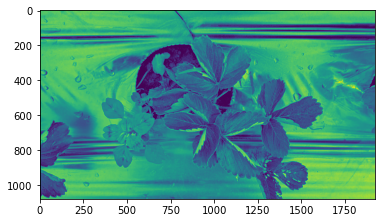

In [31]:
plt.imshow(image_dataset[5])

## Read the masks

In [34]:
masks = glob.glob("/Users/apple/Desktop/mlFinal/mask/*.png")
masks.sort()
masks = [cv2.imread(mask, 0) for mask in masks]
mask_dataset = np.array(masks)
print("mask_dataset shape is: ", mask_dataset.shape)

mask_dataset shape is:  (1000, 1080, 1920)


In [35]:
print("Image data shape is: ", image_dataset.shape)
print("mask_dataset shape is: ", mask_dataset.shape)
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (1000, 1080, 1920)
mask_dataset shape is:  (1000, 1080, 1920)
Labels in the mask are :  [ 0 38 75]


## Resize the mask into 256 x 256

mask_dataset is:  (1000, 360, 640)


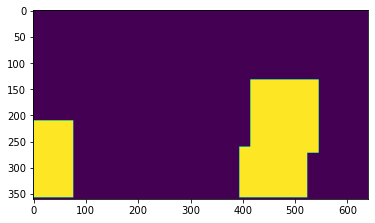

In [40]:
mask_dataset_resized = []

for mask in mask_dataset:
  mask_dataset_resized.append(cv2.resize(mask, (640, 360), interpolation=cv2.INTER_NEAREST))

mask_dataset = np.array(mask_dataset_resized)
print("mask_dataset is: ", mask_dataset.shape)
plt.imshow(mask_dataset[5])

## Resize the img into 640 x 360

image_dataset.shape: (1000, 360, 640)


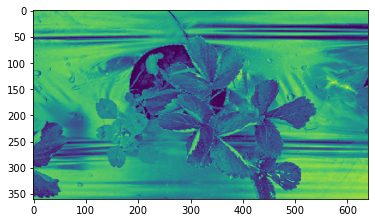

In [41]:
image_dataset_resized = []

for img in image_dataset:
  image_dataset_resized.append(cv2.resize(img, (640, 360), interpolation=cv2.INTER_NEAREST))

image_dataset = np.array(image_dataset_resized)
print('image_dataset.shape:' ,image_dataset.shape)
plt.imshow(image_dataset[5])

## Encode mask label into 0, 1, 2

*   欲使用 LabelEncoder 將 Label標準化
*   但 LabelEncoder 只能作用於 1 dim
*   故須先將 mask_dataset 做 flattern，變成 1 dim
*   Encode 完之後，再將其 reshape 成原本的維度




In [42]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [43]:
n, h, w = mask_dataset.shape

mask_dataset_tmp = mask_dataset.reshape(-1,1)
mask_dataset_tmp = labelencoder.fit_transform(mask_dataset_tmp)
mask_dataset = mask_dataset_tmp.reshape(n, h, w)

print('mask_dataset.shape: ',mask_dataset.shape)
print("Labels in the mask are : " ,np.unique(mask_dataset))

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mask_dataset.shape:  (1000, 360, 640)
Labels in the mask are :  [0 1 2]


## Visualize the data and label after preprocessed

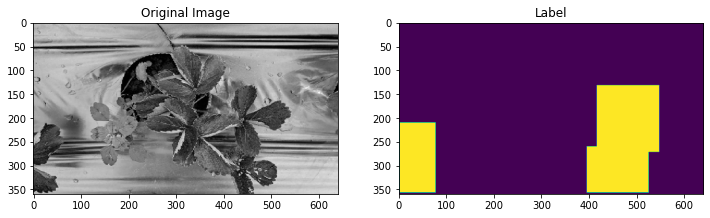

In [44]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Original Image')
plt.imshow(image_dataset[5], cmap='gray')


plt.subplot(222)
plt.title('Label')
plt.imshow(mask_dataset[5])

plt.show()

## Normalize images

In [45]:
print("Max pixel value in image is: ", image_dataset.max())
image_dataset = image_dataset /255.

Max pixel value in image is:  255


# Divide data into train and test

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.2, random_state = 42)

In [47]:
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)

X_train.shape: (800, 360, 640)
y_train.shape: (800, 360, 640)
X_test.shape: (200, 360, 640)
y_test.shape: (200, 360, 640)


## 將整數型 label 轉為 one-hot encoding


*   其中 num_classes 為標籤類別總數
*   mask 應變為 3 個維度，在每一個維度上，每個 pixel 會有對應之機率



In [48]:
from tensorflow.keras.utils import to_categorical

train_masks_cat = to_categorical(y_train, num_classes = n_classes)
# print('train_masks_cat.shape: ' ,train_masks_cat.shape)

y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
print('y_train_cat.shape: ', y_train_cat.shape)

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
# print('test_masks_cat.shape: ', test_masks_cat.shape)

y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
print('y_test_cat.shape: ', y_test_cat.shape)

ModuleNotFoundError: No module named 'tensorflow'

使得 X-train, X-test 維度與 y 相同

In [33]:
X_train = np.expand_dims(X_train, 3)
print('X_train.shape:' ,X_train.shape)

X_test = np.expand_dims(X_test, 3)
print('X_test.shape:' ,X_test.shape)

X_train.shape: (880, 256, 256, 1)
X_test.shape: (220, 256, 256, 1)


# Build up model

In [49]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

ModuleNotFoundError: No module named 'keras'

## Convolution block in U-Net

In [42]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

## Encoder block in U-Net

In [36]:
# Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

## Decoder block in U-Net

In [37]:
def decoder_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## bottleneck in U-Net

In [38]:
def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## Build up whole U-Net

In [44]:
def UNet(input_shape, n_classes):
    f = [16, 32, 64, 128, 256]
    inputs = Input(input_shape)
    
    p0 = inputs
    e1, p1 = encoder_block(inputs, f[0])
    e2, p2 = encoder_block(p1, f[1])
    e3, p3 = encoder_block(p2, f[2])
    e4, p4 = encoder_block(p3, f[3])
    
    bn = bottleneck(p4, f[4])

    d1 = decoder_block(bn, e4, f[3])
    d2 = decoder_block(d1, e3, f[2])
    d3 = decoder_block(d2, e2, f[1])
    d4 = decoder_block(d3, e1, f[0])

    # Choose activation fun. by classes we want to distinguish
    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'


    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)
    print('classes is/are:', n_classes)
    print('so we use "', activation, '" to be our activation fun.')

    model = Model(inputs, outputs)
    return model

# Build up and compile the model

In [40]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [45]:
model = UNet(input_shape, n_classes=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

classes is/are: 3
so we use " softmax " to be our activation fun.


# Train the model

In [46]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=3, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Epoch 1/3
55/55 [==============================] - 24s 205ms/step - loss: 0.4942 - accuracy: 0.8506 - val_loss: 0.5225 - val_accuracy: 0.8522
Epoch 2/3
55/55 [==============================] - 9s 169ms/step - loss: 0.4015 - accuracy: 0.8648 - val_loss: 0.6213 - val_accuracy: 0.8522
Epoch 3/3
55/55 [==============================] - 9s 169ms/step - loss: 0.3863 - accuracy: 0.8648 - val_loss: 0.8051 - val_accuracy: 0.8522


# Save the model

In [26]:
model.save('unet_0103.hdf5')

# Visualization of training process


*   Loss fun
*   accuracy



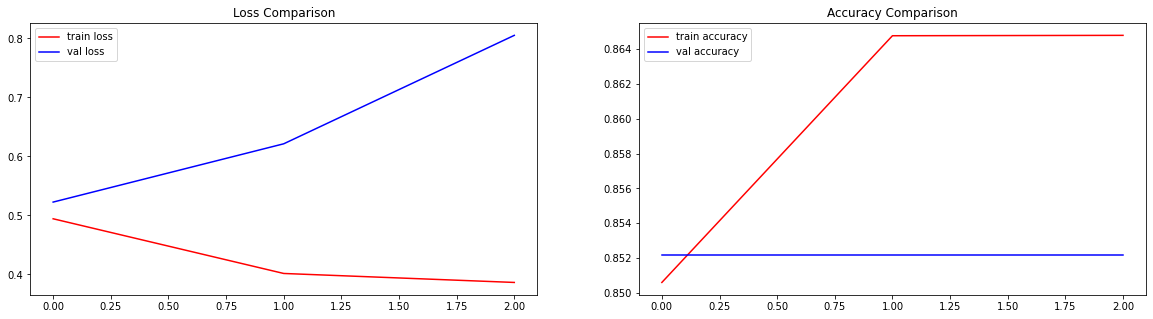

In [47]:
# #plot the training and validation accuracy and loss at each epoch

fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(history.history["loss"], color='r', label = 'train loss')
axis[0].plot(history.history["val_loss"], color='b', label = 'val loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(history.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(history.history["val_accuracy"], color='b', label = 'val accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

# Load the model we has saved

In [48]:
from keras.models import load_model
model = load_model("unet_80.hdf5", compile=True)

OSError: ignored

# Predict unknown data with our model

In [60]:
y_pred = model.predict(X_test)
print('y_pred.shape:' ,y_pred.shape)

7/7 [==============================] - 21s 2s/step
y_pred.shape: (220, 256, 256, 3)


In [61]:
print("Unique in y_pred : ", np.unique(y_pred))

y_pred_argmax = np.argmax(y_pred, axis=3)
print("Unique in y_pred_argmax : ", np.unique(y_pred_argmax))

Unique in y_pred :  [4.4459145e-22 8.0309721e-22 9.4800321e-22 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
Unique in y_pred_argmax :  [0 1 2]
y_pred_argmax.shape: (220, 256, 256)


# Visualization the result 

In [66]:
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]

ground_truth = y_test[test_img_number]
print('ground_truth.shape:',ground_truth.shape)

test_img_norm = test_img[:,:,0][:,:,None]
print('test_img_norm.shape:', test_img_norm.shape)

test_img_input = np.expand_dims(test_img_norm, 0)
print('test_img_input.shape:', test_img_input.shape)

prediction = (model.predict(test_img_input))
print('prediction.shape:', prediction.shape)

predicted_img = np.argmax(prediction, axis=3)[0,:,:]
print('predicted_img.shape:', prediction.shape)

ground_truth.shape: (256, 256)
test_img_norm.shape: (256, 256, 1)
test_img_input.shape: (1, 256, 256, 1)
1/1 [==============================] - 0s 19ms/step
prediction.shape: (1, 256, 256, 3)
predicted_img.shape: (1, 256, 256, 3)


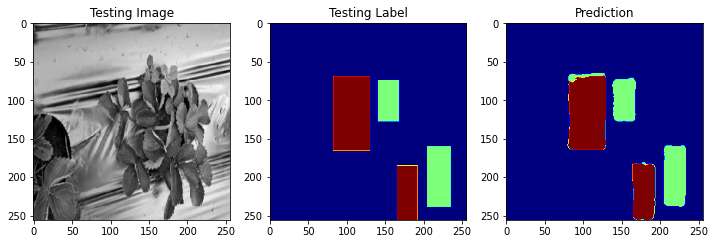

In [67]:
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='jet')

plt.subplot(233)
plt.title('Prediction')
plt.imshow(predicted_img, cmap='jet')
plt.show()

# Evaluate our model performance

In [55]:
model.evaluate(X_test, y_test_cat)

7/7 [==============================] - 1s 109ms/step - loss: 0.8051 - accuracy: 0.8522


[0.8050668239593506, 0.8521935343742371]